## Import Packages

In [1]:
from data import shortestpath, dataset
from model import shortestPathModel
from func import blackboxOpt
from evalm import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

## Build Model 

In [3]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [4]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
def train(dataloader, opt_model, num_epochs, learning_rate, lambd=10, l1_lambda=1e-3):
    """
    train model with Black-Box Optimizer
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      lambda: black-box optimizer parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
    # set loss
    criterion = nn.L1Loss()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # linear regression
            cp = lr(x)
            # black-box optimizer
            wp = blackboxOpt.apply(opt_model, cp, lambd)
            # objective value
            zp = (wp * c).sum(1).view(-1, 1)
            # l1 loss
            loss = criterion(zp, z)
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # learning rate decay
            cur_lr = learning_rate * 0.6 ** math.floor((epoch / num_epochs) * 10)
            for param_group in optimizer.param_groups:
                param_group['lr'] = cur_lr
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [6]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [7]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [8]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 455.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s]


Normalized SPO Loss: 2.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 426.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 428.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]


Normalized SPO Loss: 2.65%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 472.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


Normalized SPO Loss: 6.95%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 466.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 433.04it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


Normalized SPO Loss: 16.12%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 487.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


Normalized SPO Loss: 1.69%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 393.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


Normalized SPO Loss: 4.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 419.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 429.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]


Normalized SPO Loss: 21.07%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 395.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.93it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]


Normalized SPO Loss: 17.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 402.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 447.10it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.17it/s]


Normalized SPO Loss: 1.12%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 273.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.54it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


Normalized SPO Loss: 2.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 471.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 445.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]


Normalized SPO Loss: 11.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 424.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 452.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.04it/s]


Normalized SPO Loss: 18.04%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 451.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.78it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


Normalized SPO Loss: 1.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 454.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 431.92it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


Normalized SPO Loss: 3.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 430.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 428.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


Normalized SPO Loss: 6.80%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 466.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 439.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


Normalized SPO Loss: 19.54%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 420.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


Normalized SPO Loss: 1.06%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 434.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


Normalized SPO Loss: 3.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 453.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


Normalized SPO Loss: 6.92%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 501.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 453.83it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


Normalized SPO Loss: 14.75%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 486.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 456.59it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


Normalized SPO Loss: 1.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 456.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 467.74it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


Normalized SPO Loss: 3.77%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 503.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 462.32it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.04it/s]


Normalized SPO Loss: 9.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 464.16it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.01it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


Normalized SPO Loss: 18.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 506.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


Normalized SPO Loss: 1.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 353.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s]


Normalized SPO Loss: 3.61%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 435.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.10it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


Normalized SPO Loss: 8.46%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 453.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.14it/s]


Normalized SPO Loss: 32.91%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 392.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 435.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


Normalized SPO Loss: 1.59%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 363.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 382.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.19it/s]


Normalized SPO Loss: 4.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 419.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.84it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


Normalized SPO Loss: 8.25%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 451.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 444.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.97it/s]


Normalized SPO Loss: 16.96%



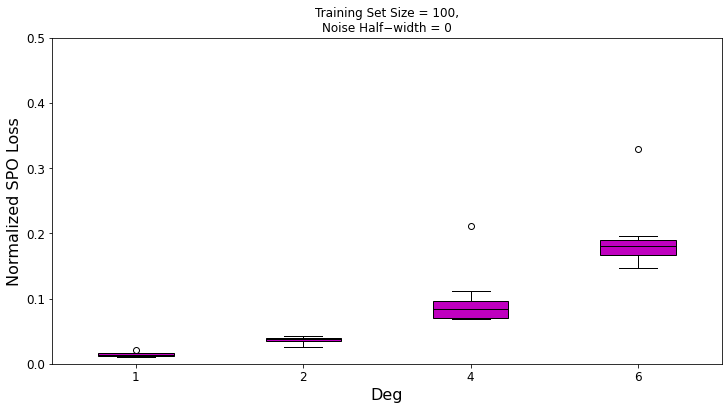

In [9]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [10]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [11]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [12]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 384.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 426.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


Normalized SPO Loss: 20.50%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 367.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 440.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s]


Normalized SPO Loss: 16.64%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 481.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 457.84it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


Normalized SPO Loss: 18.76%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 484.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 457.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


Normalized SPO Loss: 22.63%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 477.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 444.22it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


Normalized SPO Loss: 20.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 486.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 436.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s]


Normalized SPO Loss: 17.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 415.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 448.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


Normalized SPO Loss: 19.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 483.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 439.93it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


Normalized SPO Loss: 24.07%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 401.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 417.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.00it/s]


Normalized SPO Loss: 20.37%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 442.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 453.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


Normalized SPO Loss: 18.04%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 454.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 474.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


Normalized SPO Loss: 17.64%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 506.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 432.20it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


Normalized SPO Loss: 32.40%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 462.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 468.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]


Normalized SPO Loss: 19.29%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 411.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 477.96it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


Normalized SPO Loss: 16.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 457.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s]


Normalized SPO Loss: 18.69%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 482.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 448.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


Normalized SPO Loss: 25.15%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 402.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.69it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]


Normalized SPO Loss: 22.60%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 506.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 467.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


Normalized SPO Loss: 18.84%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 372.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


Normalized SPO Loss: 17.88%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 424.87it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 422.65it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


Normalized SPO Loss: 18.45%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 416.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.73it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.21it/s]


Normalized SPO Loss: 21.15%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 345.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


Normalized SPO Loss: 18.44%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 296.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.75it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.17it/s]


Normalized SPO Loss: 15.01%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 404.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 378.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


Normalized SPO Loss: 24.44%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 497.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.09it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


Normalized SPO Loss: 20.89%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 377.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 407.79it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


Normalized SPO Loss: 16.48%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 468.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 430.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


Normalized SPO Loss: 18.57%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 435.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 433.74it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


Normalized SPO Loss: 31.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 455.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 442.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


Normalized SPO Loss: 20.70%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 490.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 447.89it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


Normalized SPO Loss: 17.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 410.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 431.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s]


Normalized SPO Loss: 15.53%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 443.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.41it/s]


Normalized SPO Loss: 28.27%



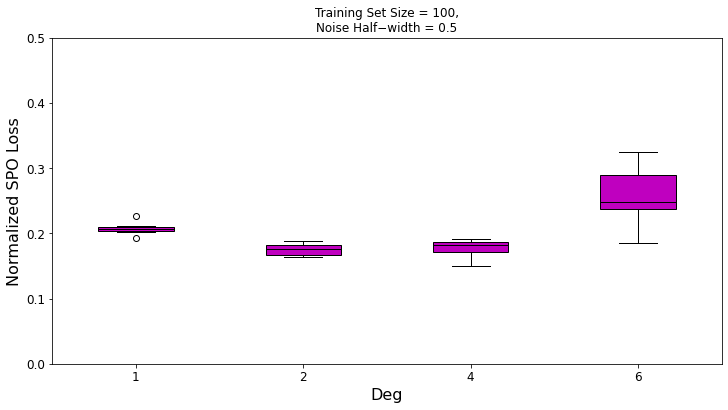

In [13]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0 

In [14]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [15]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [16]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 30
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 476.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 521.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:27<00:00,  4.92s/it]


Normalized SPO Loss: 0.57%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 457.23it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 457.22it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:14<00:00,  4.48s/it]


Normalized SPO Loss: 3.16%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 447.83it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:15<00:00,  4.50s/it]


Normalized SPO Loss: 8.35%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 448.42it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:18<00:00,  4.62s/it]


Normalized SPO Loss: 11.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 428.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 458.68it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:14<00:00,  4.48s/it]


Normalized SPO Loss: 0.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 469.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 450.80it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:16<00:00,  4.54s/it]


Normalized SPO Loss: 3.59%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 437.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 443.63it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:16<00:00,  4.56s/it]


Normalized SPO Loss: 11.76%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 468.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 448.23it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:08<00:00,  4.30s/it]


Normalized SPO Loss: 14.26%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 488.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.87it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.97s/it]


Normalized SPO Loss: 0.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 507.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.25it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.97s/it]


Normalized SPO Loss: 3.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 515.49it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:05<00:00,  4.17s/it]


Normalized SPO Loss: 6.51%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 497.86it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 12.16%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 522.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 498.05it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  4.00s/it]


Normalized SPO Loss: 0.41%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 452.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.94it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.01s/it]


Normalized SPO Loss: 2.80%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 509.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.97it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 6.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 514.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 524.74it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.00s/it]


Normalized SPO Loss: 12.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 514.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 487.15it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.01s/it]


Normalized SPO Loss: 0.24%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 496.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 513.42it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.02s/it]


Normalized SPO Loss: 1.95%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 507.45it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:01<00:00,  4.06s/it]


Normalized SPO Loss: 10.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 491.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 521.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 19.29%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 503.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 517.12it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.98s/it]


Normalized SPO Loss: 0.73%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 446.62it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 457.01it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:58<00:00,  3.96s/it]


Normalized SPO Loss: 3.24%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 482.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 496.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.97s/it]


Normalized SPO Loss: 10.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 515.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.61it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.03s/it]


Normalized SPO Loss: 13.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 507.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 522.84it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.00s/it]


Normalized SPO Loss: 1.00%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 516.58it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.97s/it]


Normalized SPO Loss: 2.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 509.95it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.97s/it]


Normalized SPO Loss: 12.47%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 495.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 513.04it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.98s/it]


Normalized SPO Loss: 16.89%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 503.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 513.40it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.98s/it]


Normalized SPO Loss: 0.37%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 516.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 477.01it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 4.71%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 457.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 487.44it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.02s/it]


Normalized SPO Loss: 10.24%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 504.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.01s/it]


Normalized SPO Loss: 10.09%



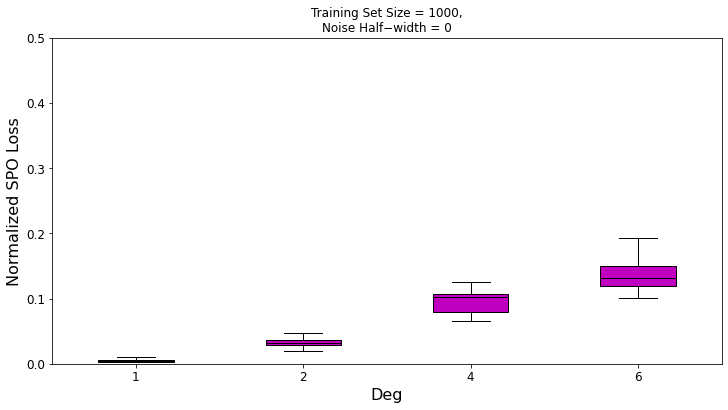

In [17]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0.5 

In [18]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [19]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [20]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2
        num_epochs = 30
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.43it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.99it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.98s/it]


Normalized SPO Loss: 20.94%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 527.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 492.00it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.98s/it]


Normalized SPO Loss: 20.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 519.52it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.00s/it]


Normalized SPO Loss: 18.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 504.73it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.97s/it]


Normalized SPO Loss: 19.02%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 509.76it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.02s/it]


Normalized SPO Loss: 23.97%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 510.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 492.18it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:05<00:00,  4.19s/it]


Normalized SPO Loss: 18.83%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 496.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.62it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 23.86%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 482.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.71it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.98s/it]


Normalized SPO Loss: 26.89%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 521.68it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 22.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 516.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.08it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 15.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 523.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.09it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 20.69%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 523.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 500.85it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:01<00:00,  4.04s/it]


Normalized SPO Loss: 17.16%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 511.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 520.86it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 20.54%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 506.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 530.35it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.98s/it]


Normalized SPO Loss: 21.14%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 472.07it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 477.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  4.00s/it]


Normalized SPO Loss: 20.74%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 518.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 510.54it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  4.00s/it]


Normalized SPO Loss: 21.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 518.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.85it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.97s/it]


Normalized SPO Loss: 20.00%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.11it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.01s/it]


Normalized SPO Loss: 19.99%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 515.79it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:01<00:00,  4.04s/it]


Normalized SPO Loss: 16.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 521.41it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 507.14it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.00s/it]


Normalized SPO Loss: 29.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 513.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 523.86it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:58<00:00,  3.96s/it]


Normalized SPO Loss: 21.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 511.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 516.31it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 20.92%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 462.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 467.88it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:01<00:00,  4.04s/it]


Normalized SPO Loss: 23.35%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 511.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.35it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  4.00s/it]


Normalized SPO Loss: 28.94%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 524.68it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.03s/it]


Normalized SPO Loss: 20.85%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 516.62it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 18.34%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 509.23it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 524.40it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.01s/it]


Normalized SPO Loss: 15.00%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 517.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.11it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:04<00:00,  4.16s/it]


Normalized SPO Loss: 18.50%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 473.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 482.35it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:10<00:00,  4.35s/it]


Normalized SPO Loss: 20.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 460.15it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 468.31it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  4.00s/it]


Normalized SPO Loss: 14.93%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 500.87it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 526.89it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [01:59<00:00,  3.99s/it]


Normalized SPO Loss: 15.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 509.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 527.85it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████████| 30/30 [02:01<00:00,  4.06s/it]


Normalized SPO Loss: 21.45%



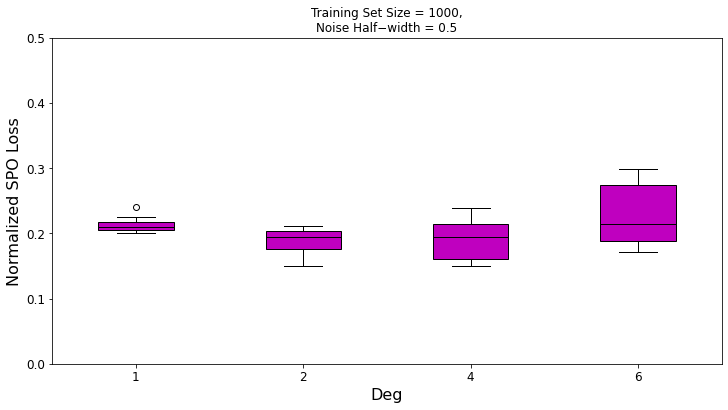

In [21]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [22]:
df1.to_csv('./res/blackbox_n100.csv', index=False)
df2.to_csv('./res/blackbox_n100_noise.csv', index=False)
df3.to_csv('./res/blackbox_n1000.csv', index=False)
df4.to_csv('./res/blackbox_n1000_noise.csv', index=False)